# Sample run for Fisher Market

In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/workspace/ExchangeMarket.jl/scripts`


In [2]:
using Revise
using Random, SparseArrays, LinearAlgebra
using JuMP, MosekTools
using Plots, LaTeXStrings, Printf
import MathOptInterface as MOI

using ExchangeMarket

include("../tools.jl")
include("../plots.jl")
include("./setup.jl")
switch_to_pdf(; bool_use_html=true)

┌ Warning: `PlotlyKaleido` 2.3.0 is not compatible with this version of `Plots`. The declared compatibility is 1.
└ @ Plots /Users/brent/.julia/packages/Plots/FFuQi/src/backends.jl:55


:html

## Test different $\rho$ in a CES Economy

Run CES economy by different methods

In [3]:
Random.seed!(1)
rrange = [-0.9, 0.9]
n = 500
m = 1000

method_filter(name) = name ∈ [:LogBar, :PathFol, :Tât, :PropRes]

method_filter (generic function with 1 method)

In [4]:
table_time = []
results = []
results_phi = Dict()
results_ground = Dict()
for ρ in rrange
    f0 = FisherMarket(m, n; ρ=ρ, bool_unit=true, scale=30.0, sparsity=0.2)
    linconstr = LinearConstr(1, n, ones(1, n), [sum(f0.w)])
    ρfmt = @sprintf("%+.2f", ρ)
    σfmt = @sprintf("%+.2f", f0.σ)
    # -----------------------------------------------------------------------
    # compute ground truth
    # -----------------------------------------------------------------------
    f1 = copy(f0)
    p₀ = ones(n) * sum(f1.w) ./ (n)
    x₀ = ones(n, m) ./ m
    f1.x .= x₀
    f1.p .= p₀
    # use log-barrier method to compute ground truth
    (name, method, kwargs) = method_kwargs[1]
    alg = method(
        n, m, p₀;
        linconstr=linconstr,
        kwargs...
    )
    traj = opt!(
        alg, f1;
        # loginterval=1,
        keep_traj=true
    )
    pₛ = copy(alg.p)
    results_phi[ρ] = pₛ
    results_ground[ρ] = (alg, traj, f1)
    for (name, method, kwargs) in method_kwargs
        !method_filter(name) && continue

        f1 = copy(f0)
        p₀ = ones(n) * sum(f1.w) ./ (n)
        x₀ = ones(n, m) ./ m
        f1.x .= x₀
        f1.p .= p₀
        alg = method(
            n, m, p₀;
            linconstr=linconstr,
            kwargs...
        )
        traj = opt!(
            alg, f1;
            keep_traj=true,
            pₛ=pₛ,
            maxiter=500
        )
        push!(results, ((name, ρ), (alg, traj, f1)))
        push!(table_time, (n, m, name, ρ, traj[end].t))
    end
end


FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.021949052810668945 seconds
FisherMarket initialized in 0.02800917625427246 seconds
FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0006721019744873047 seconds
FisherMarket initialized in 0.0007169246673583984 seconds
--------------------------------------------------------------------------------------------
                   ExchangeMarket.jl: A Julia Package for Exchange Market                   
                                    © Chuwen Zhang (2024)                                    
--------------------------------------------------------------------------------------------
 subproblem solver alias       := CESAnalytic
 subproblem solver style       := analytic
 lin-system solver alias       := DRq
 option for gradient           := dual
 option for step               := logbar
 option for μ                  := pred_corr
---------------------------------------------

## Validate the ground truth

In [5]:
for (ρ, (alg, traj, f1)) in results_ground
    validate(f1, alg)
end

------------------------------------------------------------
 :problem size
 :    number of agents: 1000
 :    number of goods: 500
 :    avg number of nonzero entries in c: 0.1997
 :equilibrium information
 :method: HessianBar
------------------------------------------------------------
10×2 DataFrame
 Row │ utility     left_budget  
     │ Float64     Float64      
─────┼──────────────────────────
   1 │ 1.24158e-7   0.0
   2 │ 3.80644e-6  -2.1684e-19
   3 │ 1.89542e-6   2.1684e-19
   4 │ 2.95614e-8   0.0
   5 │ 1.29002e-6   1.0842e-19
   6 │ 4.36207e-7  -5.42101e-20
   7 │ 1.79382e-6  -6.50521e-19
   8 │ 1.21595e-6   1.0842e-19
   9 │ 1.31283e-7  -1.35525e-20
  10 │ 2.68664e-6   4.33681e-19
------------------------------------------------------------
 :(normalized) market excess: [-5.6658e-10, 5.1747e-10]
 :            social welfare:  -1.30839518e+01
------------------------------------------------------------
------------------------------------------------------------
 :problem s

## Plot trajectory 

for each $\rho$, we plot the distance to ground truth $\|p - p^*\|$ of the trajectory.

In [6]:
ffs = []
for ρ in rrange
    for attr in [:k]
        ρfmt = @sprintf("%+.2f", ρ)
        σfmt = @sprintf("%+.2f", ρ / (1 - ρ))
        fig = generate_empty(; shape=:wide)
        plot!(
            fig,
            ylabel=L"$\|\mathbf{p} - \mathbf{p}^*\|$",
            title=L"$\rho := %$ρfmt~(\sigma := %$σfmt)$",
            legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
            yticks=10.0 .^ (-16:4:3),
            xtickfont=font(18),
            ytickfont=font(18),
            xscale=:identity,
            size=(1200, 600)
        )
        if attr == :k
            plot!(
                fig,
                xticks=[10, 20, 50, 100, 200, 500]
            )
        end
        for ((mm, _ρ), (alg, traj, f1)) in results
            if _ρ != ρ
                continue
            end
            traj_pp₊ = map(pp -> pp.D, traj)
            traj_tt₊ = map(pp -> getfield(pp, attr), traj)
            plot!(fig, traj_tt₊, traj_pp₊, label=L"\texttt{%$mm}", linewidth=2, linestyle=:dash, markershape=:circle)
        end
        push!(ffs, fig)
    end
end

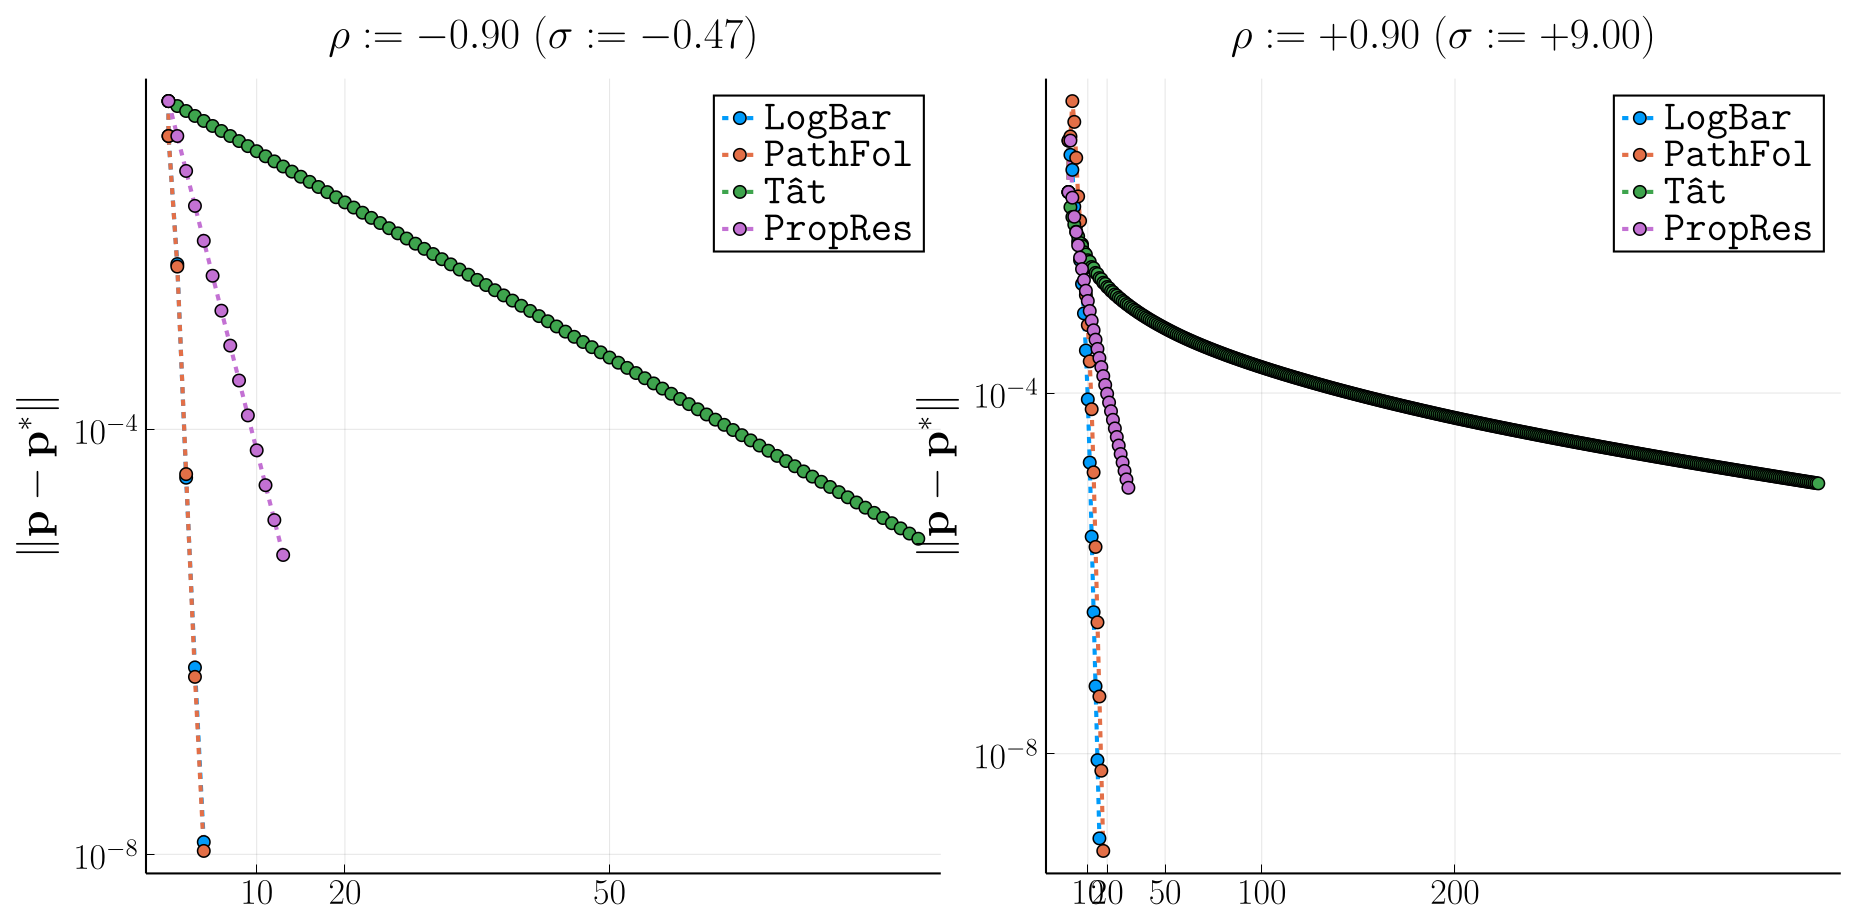

In [7]:
plot(ffs...)